In [1]:
!pip install pytorch-lightning

In [2]:
!pip install thop

In [3]:
!pip install clearml

In [10]:
import torch
import torchaudio
import torchaudio.transforms as T
from torchaudio.datasets import SPEECHCOMMANDS
from torch.utils.data import Dataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from time import time
from melbanks import LogMelFilterBanks
from thop import profile  # For FLOPs calculation
from clearml import Task  # ClearML integration

In [11]:
from thop import profile  # For FLOPs calculation
import pytorch_lightning as pl

In [12]:
# Укажите путь, куда будут скачаны данные
dataset_path = "/content/data"

# Создаем объект датасета
dataset = SPEECHCOMMANDS(root=dataset_path, download=True)

# Проверим размер датасета
print(f"Размер датасета: {len(dataset)}")

Размер датасета: 105829


In [ ]:
# Initialize ClearML task
task = Task.init(project_name="SpeechCommands", task_name="Experiment")

# Dataset and preprocessing setup (same as before)
dataset_path = "/content/data"
dataset = SPEECHCOMMANDS(root=dataset_path, download=True)

class FilteredSpeechCommandsDataset(Dataset):
    def __init__(self, original_dataset, allowed_labels):
        self.original_dataset = original_dataset
        self.allowed_labels = allowed_labels
        self.filtered_indices = [
            i for i, (_, _, label, _, _) in enumerate(original_dataset)
            if label in allowed_labels
        ]

    def __len__(self):
        return len(self.filtered_indices)

    def __getitem__(self, idx):
        original_idx = self.filtered_indices[idx]
        waveform, sample_rate, label, speaker_id, utterance_number = self.original_dataset[original_idx]

        if sample_rate != 16000:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
            waveform = resampler(waveform)

        current_length = waveform.size(1)
        if current_length > 16000:
            waveform = waveform[:, :16000]
        elif current_length < 16000:
            padding = 16000 - current_length
            waveform = torch.nn.functional.pad(waveform, (0, padding))

        label = 0 if label == "yes" else 1
        return waveform, label

allowed_labels = ['yes', 'no']
filtered_dataset = FilteredSpeechCommandsDataset(dataset, allowed_labels)

log_mel_filter_banks = LogMelFilterBanks(
    n_fft=400,
    samplerate=16000,
    hop_length=160,
    n_mels=80,
    f_min_hz=0.0,
    f_max_hz=None
).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

batch_size = 32
data_loader = DataLoader(filtered_dataset, batch_size=batch_size, shuffle=True)

spectrograms, labels = [], []
for batch_audio, batch_labels in data_loader:
    # Move data to the appropriate device
    batch_audio = batch_audio.to(device)

    # Remove the channel dimension
    batch_audio = batch_audio.squeeze(1)  # Shape: [batch_size, time]

    # Generate log mel spectrograms
    batch_spectrograms = log_mel_filter_banks(batch_audio)

    # Store the results
    spectrograms.append(batch_spectrograms.cpu().detach())
    labels.extend(batch_labels)
# Concatenate all spectrograms into a single tensor
spectrograms = torch.cat(spectrograms, dim=0)
train_spectrograms, val_spectrograms, train_labels, val_labels = train_test_split(
    spectrograms, labels, test_size=0.2, random_state=42
)
train_labels, val_labels = torch.tensor(train_labels), torch.tensor(val_labels)

Training with n_mels=20, groups=1
Epoch [1/10], Loss: 0.1742, Val Accuracy: 0.9336, Time: 13.64s
Epoch [2/10], Loss: 0.1042, Val Accuracy: 0.9343, Time: 15.23s
Epoch [3/10], Loss: 0.0834, Val Accuracy: 0.9349, Time: 13.71s
Epoch [4/10], Loss: 0.0729, Val Accuracy: 0.9624, Time: 13.88s
Epoch [5/10], Loss: 0.0644, Val Accuracy: 0.9393, Time: 13.51s
Epoch [6/10], Loss: 0.0609, Val Accuracy: 0.9606, Time: 13.47s
Epoch [7/10], Loss: 0.0563, Val Accuracy: 0.9699, Time: 14.84s
Epoch [8/10], Loss: 0.0503, Val Accuracy: 0.9411, Time: 13.46s
Epoch [9/10], Loss: 0.0485, Val Accuracy: 0.9662, Time: 15.35s
Epoch [10/10], Loss: 0.0466, Val Accuracy: 0.9649, Time: 13.55s
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool1d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Training with n_mels=20, groups=2
Epoch [1/10], Loss: 0.1797, Val Accuracy: 0.9568, Time: 13.71s
Epoch [2/

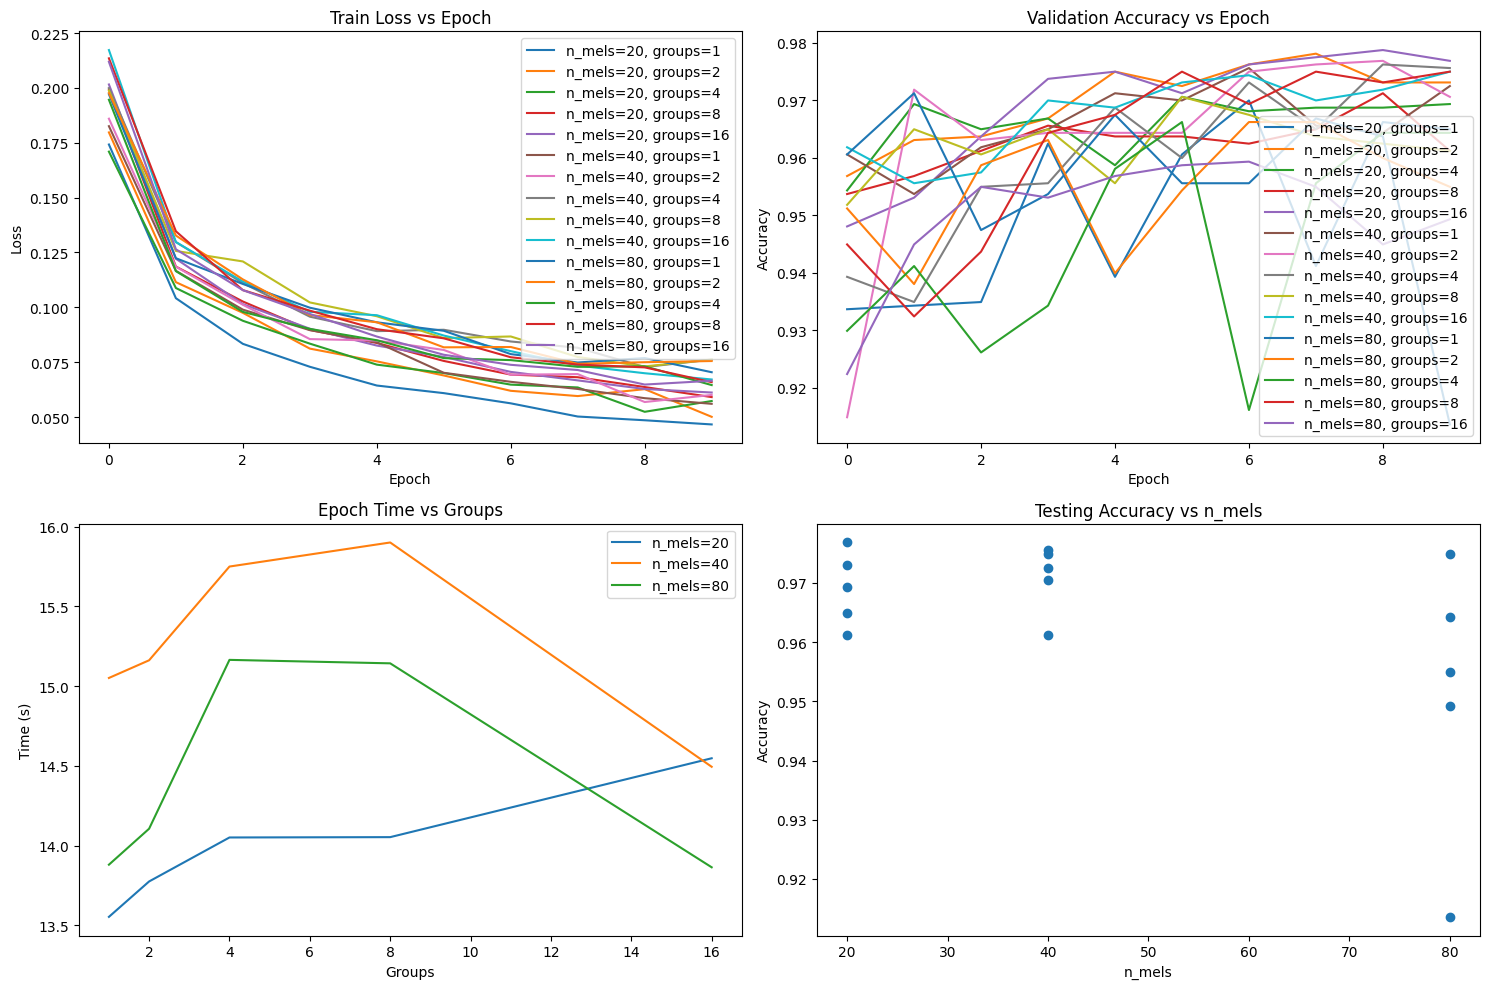

n_mels=20, groups=1 -> Params: 204866, FLOPs: 568448.0, Final Accuracy: 0.9649
n_mels=20, groups=2 -> Params: 203330, FLOPs: 416384.0, Final Accuracy: 0.9731
n_mels=20, groups=4 -> Params: 202562, FLOPs: 340352.0, Final Accuracy: 0.9693
n_mels=20, groups=8 -> Params: 202178, FLOPs: 302336.0, Final Accuracy: 0.9612
n_mels=20, groups=16 -> Params: 201986, FLOPs: 283328.0, Final Accuracy: 0.9768
n_mels=40, groups=1 -> Params: 205506, FLOPs: 631808.0, Final Accuracy: 0.9724
n_mels=40, groups=2 -> Params: 203970, FLOPs: 479744.0, Final Accuracy: 0.9706
n_mels=40, groups=4 -> Params: 203202, FLOPs: 403712.0, Final Accuracy: 0.9756
n_mels=40, groups=8 -> Params: 202818, FLOPs: 365696.0, Final Accuracy: 0.9612
n_mels=40, groups=16 -> Params: 202626, FLOPs: 346688.0, Final Accuracy: 0.9750
n_mels=80, groups=1 -> Params: 206786, FLOPs: 758528.0, Final Accuracy: 0.9136
n_mels=80, groups=2 -> Params: 205250, FLOPs: 606464.0, Final Accuracy: 0.9549
n_mels=80, groups=4 -> Params: 204482, FLOPs: 5304

In [32]:
def generate_spectrograms(n_mels):
    # Reinitialize LogMelFilterBanks with the new n_mels value
    global log_mel_filter_banks
    log_mel_filter_banks = LogMelFilterBanks(
        n_fft=400,
        samplerate=16000,
        hop_length=160,
        n_mels=n_mels,
        f_min_hz=0.0,
        f_max_hz=None
    ).to(device)

    spectrograms, labels = [], []
    for batch_audio, batch_labels in data_loader:
        # Move data to the appropriate device
        batch_audio = batch_audio.to(device)

        # Remove the channel dimension
        batch_audio = batch_audio.squeeze(1)  # Shape: [batch_size, time]

        # Generate log mel spectrograms
        batch_spectrograms = log_mel_filter_banks(batch_audio)

        # Store the results
        spectrograms.append(batch_spectrograms.cpu().detach())
        labels.extend(batch_labels)
    spectrograms = torch.cat(spectrograms, dim=0)
    return spectrograms, labels

class SimpleCNN1D(nn.Module):
    def __init__(self, num_classes=2, groups=1, n_mels=80):
        super(SimpleCNN1D, self).__init__()

        # Initial convolution to increase input channels
        self.initial_conv = nn.Conv1d(n_mels, 32, kernel_size=1, stride=1, padding=0)

        # Main convolutional layer with groups
        self.conv1 = nn.Conv1d(32, 32, kernel_size=3, stride=1, padding=1, groups=groups)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # fc1 will be initialized dynamically during the first forward pass
        self.fc1_input_size = None
        self.fc1 = None
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.relu(self.initial_conv(x))  # Map input to 32 channels
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)  # Flatten

        # Dynamically initialize fc1 if not already initialized
        if self.fc1 is None:
            self.fc1_input_size = x.size(1)  # Calculate input size dynamically
            self.fc1 = nn.Linear(self.fc1_input_size, 128).to(x.device)

        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def initialize_fc1(self, dummy_input):
        """Explicitly initialize fc1 using a dummy input tensor."""
        x = torch.relu(self.initial_conv(dummy_input))
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)  # Flatten
        self.fc1_input_size = x.size(1)
        self.fc1 = nn.Linear(self.fc1_input_size, 128).to(dummy_input.device)

def train_and_evaluate(n_mels, groups):
    # Regenerate spectrograms based on the current n_mels value
    spectrograms, labels = generate_spectrograms(n_mels)

    # Split into training and validation sets
    train_spectrograms, val_spectrograms, train_labels, val_labels = train_test_split(
        spectrograms, labels, test_size=0.2, random_state=42
    )
    train_labels, val_labels = torch.tensor(train_labels), torch.tensor(val_labels)

    # Initialize the model
    model = SimpleCNN1D(num_classes=2, groups=groups, n_mels=n_mels).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_accuracies, epoch_times = [], [], []

    for epoch in range(10):
        start_time = time()
        model.train()
        epoch_loss = 0
        for spectrogram, label in zip(train_spectrograms, train_labels):
            # Reshape input for Conv1d: (batch_size, n_mels, time_frames)
            spectrogram = spectrogram.unsqueeze(0).to(device)  # Add batch dimension
            label = label.unsqueeze(0).to(device)

            optimizer.zero_grad()
            outputs = model(spectrogram)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        epoch_time = time() - start_time
        train_losses.append(epoch_loss / len(train_spectrograms))
        epoch_times.append(epoch_time)

        model.eval()
        correct = 0
        with torch.no_grad():
            for spectrogram, label in zip(val_spectrograms, val_labels):
                spectrogram = spectrogram.unsqueeze(0).to(device)
                label = label.unsqueeze(0).to(device)
                outputs = model(spectrogram)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == label).sum().item()
        val_accuracy = correct / len(val_spectrograms)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/10], Loss: {train_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}, Time: {epoch_time:.2f}s")

    # Log metrics to ClearML
    task.get_logger().report_scalar("Train Loss", f"n_mels={n_mels}, groups={groups}", iteration=epoch, value=train_losses[-1])
    task.get_logger().report_scalar("Validation Accuracy", f"n_mels={n_mels}, groups={groups}", iteration=epoch, value=val_accuracies[-1])
    task.get_logger().report_scalar("Epoch Time", f"n_mels={n_mels}, groups={groups}", iteration=epoch, value=epoch_times[-1])

    # Explicitly initialize fc1 before calculating FLOPs
    dummy_input = torch.randn(1, n_mels, 99).to(device)  # Adjust shape based on n_mels
    model.initialize_fc1(dummy_input)

    # Calculate and log model parameters and FLOPs
    params = count_parameters(model)
    flops, _ = profile(model, inputs=(dummy_input,))
    task.get_logger().report_scalar("Model Parameters", f"n_mels={n_mels}, groups={groups}", iteration=0, value=params)
    task.get_logger().report_scalar("FLOPs", f"n_mels={n_mels}, groups={groups}", iteration=0, value=flops)

    return train_losses, val_accuracies, epoch_times, params, flops

# Experiment with n_mels and groups
results = []
for n_mels in [20, 40, 80]:
    for groups in [1, 2, 4, 8, 16]:
        print(f"Training with n_mels={n_mels}, groups={groups}")
        train_losses, val_accuracies, epoch_times, params, flops = train_and_evaluate(n_mels, groups)
        results.append({
            "n_mels": n_mels,
            "groups": groups,
            "train_losses": train_losses,
            "val_accuracies": val_accuracies,
            "epoch_times": epoch_times,
            "params": params,
            "flops": flops
        })

# Generate plots and conclusions
plt.figure(figsize=(15, 10))

# Plot train losses
plt.subplot(2, 2, 1)
for result in results:
    plt.plot(result["train_losses"], label=f"n_mels={result['n_mels']}, groups={result['groups']}")
plt.title("Train Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot validation accuracies
plt.subplot(2, 2, 2)
for result in results:
    plt.plot(result["val_accuracies"], label=f"n_mels={result['n_mels']}, groups={result['groups']}")
plt.title("Validation Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Plot epoch times vs groups
plt.subplot(2, 2, 3)
for n_mels in [20, 40, 80]:
    groups = [result["groups"] for result in results if result["n_mels"] == n_mels]
    times = [result["epoch_times"][-1] for result in results if result["n_mels"] == n_mels]
    plt.plot(groups, times, label=f"n_mels={n_mels}")
plt.title("Epoch Time vs Groups")
plt.xlabel("Groups")
plt.ylabel("Time (s)")
plt.legend()

# Plot n_mels vs testing accuracy
plt.subplot(2, 2, 4)
n_mels_values = [result["n_mels"] for result in results]
accuracies = [result["val_accuracies"][-1] for result in results]
plt.scatter(n_mels_values, accuracies)
plt.title("Testing Accuracy vs n_mels")
plt.xlabel("n_mels")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()

# Dump conclusions
for result in results:
    print(f"n_mels={result['n_mels']}, groups={result['groups']} -> Params: {result['params']}, FLOPs: {result['flops']}, Final Accuracy: {result['val_accuracies'][-1]:.4f}")